# Lyrics analysis

In [1]:
# Import libraries
import pandas as pd
from ast import literal_eval
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from statistics import mode
from nltk import FreqDist
import numpy as np

In [2]:
# Load data with keeping structures inside data frame
songs = pd.read_csv('lyrics_processed_data.csv', converters={'Tokenized Lyrics': literal_eval, 'Lemmatized Words': literal_eval, 'Parts of Speech': literal_eval, 'Adjectives': literal_eval, 'Nouns': literal_eval, 'Adverbs': literal_eval, 'Pronouns': literal_eval, 'Verbs': literal_eval,})
display(songs)

,Position,Artist,Song Title,Year,JSON file,Split Names,Song Language,Lyrics,Cleaned Lyrics,Tokenized Lyrics,Lemmatized Words,Parts of Speech,Adjectives,Nouns,Adverbs,Pronouns,Verbs
0,1,Gordon Jenkins and The Weavers,Goodnight Irene,1950,0.json,Gordon Jenkins,en,goodnight irene lyricsirene goodnight irene go...,goodnight irene lyricsirene goodnight irene go...,"[goodnight, irene, lyricsirene, goodnight, ire...","[goodnight, irene, lyricsirene, goodnight, ire...","[(goodnight, JJ), (irene, NN), (lyricsirene, N...","[goodnight, irene, goodnight, last, saturday, ...","[irene, lyricsirene, goodnight, irene, irene, ...","[down, now, sometimes, sometimes, sometimes, l...","[you, me, me, you, you, you, you]","[take, jump, stop, stop]"
1,2,Nat King Cole,Mona Lisa,1950,1.json,Nat King Cole,en,mona lisa lyrics mona lisa mona lisa men have ...,mona lisa mona lisa mona lisa men named youre ...,"[mona, lisa, lyrics, mona, lisa, mona, lisa, m...","[mona, lisa, lyric, mona, lisa, mona, lisa, me...","[(mona, NN), (lisa, VBZ), (lyric, JJ), (mona, ...","[lyric, mystic, broken, many, warm, real, mona...","[mona, mona, lisa, mona, lady, smile, youre, m...","[so, only, lonely, just, there, just, lonely, ...","[you, it, they, you, you, they, they, you, you...","[smile, tempt, hide, lie, smile, tempt, hide, ..."
2,4,Gary and Bing Crosby,Sam's Song,1950,3.json,Gary,en,sam’s song lyricsah heres a happy tune youll l...,sam’s song lyricsah heres happy tune youll lov...,"[sam, ’, s, song, lyricsah, heres, a, happy, t...","[sam, ’, s, song, lyricsah, here, a, happy, tu...","[(sam, NN), (’, NNP), (s, NN), (song, NN), (ly...","[happy, song, youre, grim, grand, smile, wrong...","[sam, s, song, lyricsah, tune, youll, love, so...","[here, then, only, soon, so, never, ah, here, ...","[they, it, it, they, it, you, it, you, you, yo...","[croon, call, be, make, get, do, agree, forget..."
3,5,Gary and Bing Crosby,Simple Melody,1950,4.json,Gary,en,play a simple melody lyricswont you play some ...,play simple melody lyricswont play simple melo...,"[play, a, simple, melody, lyricswont, you, pla...","[play, a, simple, melody, lyricswont, you, pla...","[(play, VB), (a, DT), (simple, JJ), (melody, N...","[simple, simple, good, old, simple, musical, c...","[melody, lyricswont, melody, mother, sang, har...","[just, simply, na, just, simply, na, just, sim...","[you, me, you, me, you, you, me, you, you, me,...","[play, play, play, rag, play, rag, play, rag, ..."
4,6,Teresa Brewer,"Music, Music, Music",1950,5.json,Teresa Brewer,en,music music music lyricsput another nickel in ...,music music music lyricsput another nickel nic...,"[music, music, music, lyricsput, another, nick...","[music, music, music, lyricsput, another, nick...","[(music, NN), (music, NN), (music, NN), (lyric...","[youd, dear, youd, dear, old]","[music, music, music, lyricsput, nickel, nicke...","[danciong, close, so, danciong, close, so]","[you, you, me, you, me, you, you, you, me, you...",[keep]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6410,95,Cole Swindell,Single Saturday Night,2021,6774.json,Cole Swindell,en,single saturday night lyrics i was out taking ...,single saturday night taking shots throwing sp...,"[single, saturday, night, lyrics, i, was, out,...","[single, saturday, night, lyric, i, wa, out, t...","[(single, JJ), (saturday, NN), (night, NN), (l...","[single, single, light, single, sittin, red, w...","[saturday, night, lyric, i, shot, spot, sheet,...","[just, not, there, nowhere, nowhere, pretty, l...","[me, them, they, me, me, you, they, me, they, ...","[catch, find, i, be, yeah, tell, i, wake, be, ..."
6411,96,Lainey Wilson,Things A Man Oughta Know,2021,6775.json,Lainey Wilson,en,things a man oughta know lyrics i can hook a t...,things man oughta know hook trailer twoinch hi...,"[things, a, man, oughta, know, lyrics, i, can,...","[thing, a, man, oughta, know, lyric, i, can, h...","[(thing, NN), (a, DT), (man, NN), (oughta, NN)...","[lyric, twoinch, fish, few, to

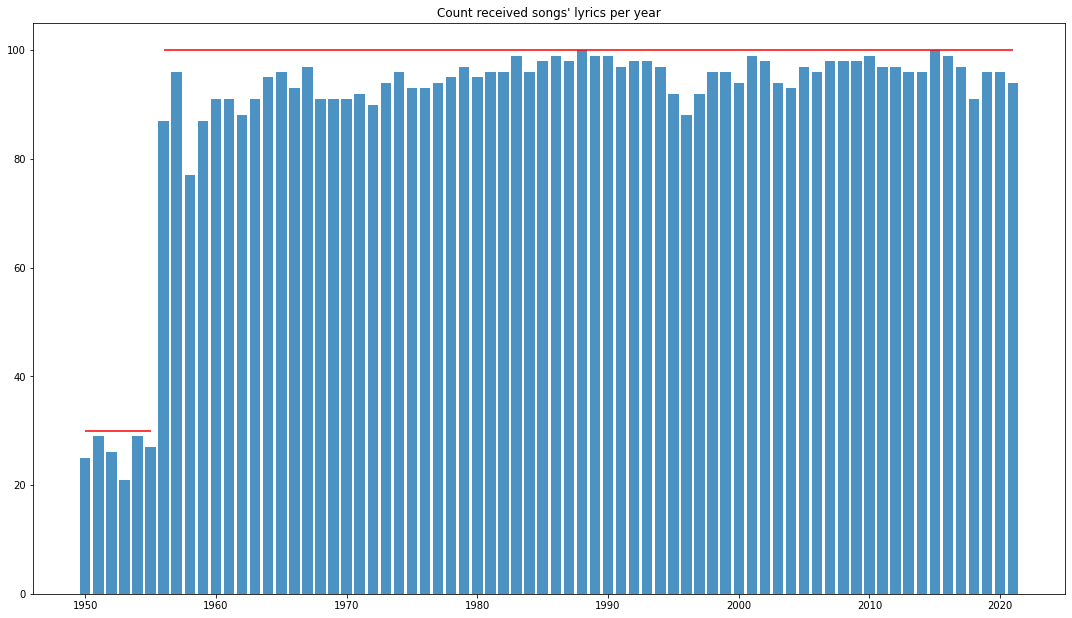

In [3]:
# Count received songs' lyrics per year
grouped_year = songs.groupby('Year').size()
plt.figure(figsize = (18.5, 10.5))
plt.bar(grouped_year.index, grouped_year, alpha = 0.8)
plt.title('Count received songs\' lyrics per year')
plt.hlines(y = 30, xmin = 1950, xmax = 1955, colors = 'r')
plt.hlines(y = 100, xmin = 1956, xmax = 2021, colors='r')

Text(0.5, 1.0, "Average number of words and unique words in songs' lyrics per year")

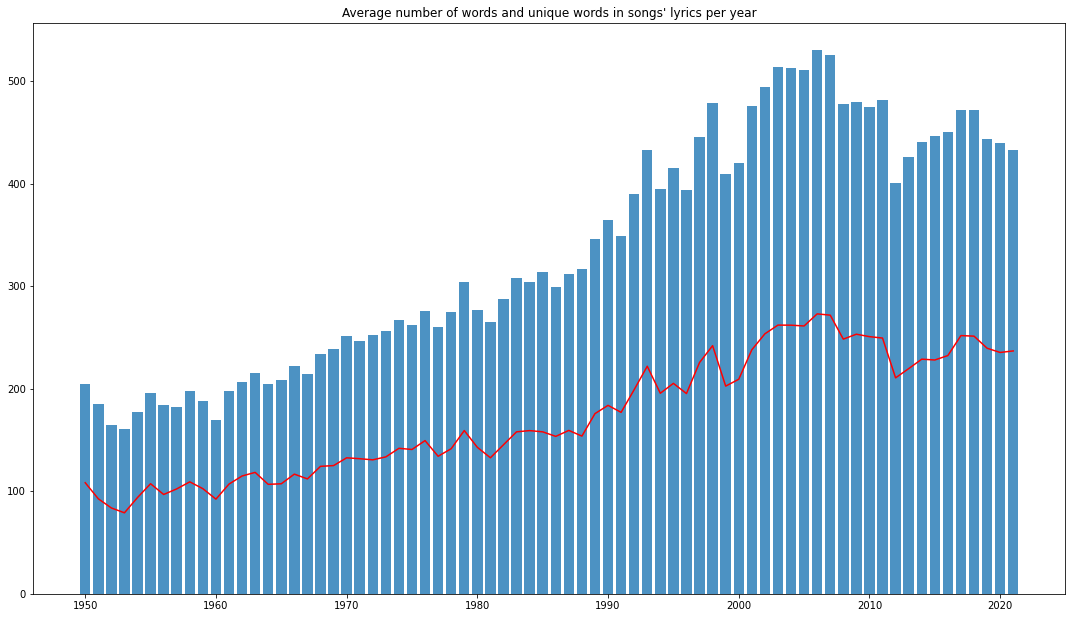

In [4]:
# Average number of words and unique in lyrics
songs['Tokenized Lyrics length'] = songs['Tokenized Lyrics'].str.len()
songs['Tokenized Unique Lyrics length'] = songs['Cleaned Lyrics'].str.split().str.len()
grouped_mean = songs.groupby('Year')['Tokenized Lyrics length'].mean()
grouped_unique_mean = songs.groupby('Year')['Tokenized Unique Lyrics length'].mean()

plt.figure(figsize = (18.5, 10.5))
plt.bar(grouped_mean.index, grouped_mean, alpha = 0.8)
plt.plot(grouped_unique_mean, color = 'r')
plt.title('Average number of words and unique words in songs\' lyrics per year')

### Word cloud

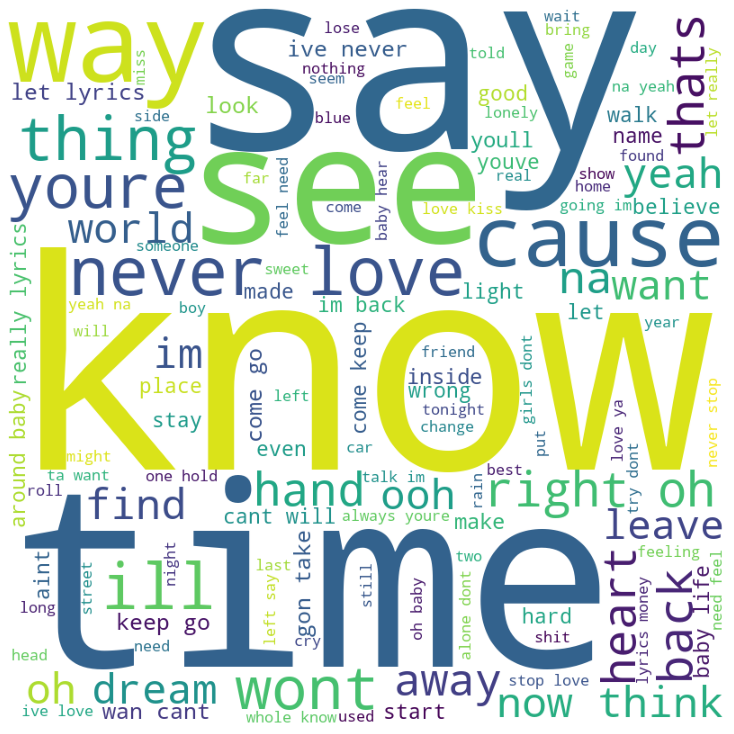

In [5]:
set_lyrics = [set(i) for i in songs['Tokenized Lyrics']]
set_lyrics = list(chain(*set_lyrics))
join_lyrics = (" ").join(set_lyrics)

STOPWORDS.add('n\'t')

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = STOPWORDS, min_font_size = 15).generate(join_lyrics)
plt.figure(figsize = (18.5, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Most popular words

In [6]:
# Three most popular words each year
analyzed_data = pd.DataFrame({'Year':list(range(1950, 2022))})
lyrics_per_year = []

# Function for converting lists to sets
def lists_to_sets(l):
    return [{i for i in row} for row in l]

# Combination of lyrics per year
for i in list(songs['Year'].unique()):
    song_lyrics = songs['Cleaned Lyrics'].str.split()[songs['Year'] == i].to_list()
    set_song_lyrics = lists_to_sets(song_lyrics)
    flat_song_lyrics = [item for i in set_song_lyrics for item in i]
    lyrics_per_year.append(flat_song_lyrics)
    
# Set for every song in particular year
analyzed_data['Combined Lyrics'] = lyrics_per_year


# Function for getting first values from tuple of most popular words
def first_from_list_of_tuples(lst):
    return [i[0] for i in lst]

lst_of_top3_words = [] 

# Create list of top 3 popular words
for i in analyzed_data['Combined Lyrics']:
    frq = FreqDist(i)
    top3_words = first_from_list_of_tuples(frq.most_common(3))
    lst_of_top3_words.append(top3_words)

# Set for every song in particular year
analyzed_data['Most Popular Words'] = lst_of_top3_words

display(analyzed_data)

,Year,Combined Lyrics,Most Popular Words
0,1950,"[gonna, home, take, lyricsirene, fireside, nig...","[love, see, like]"
1,1951,"[though, know, someday, begin, may, tell, alle...","[love, heart, youre]"
2,1952,"[lyricsthe, smile, know, flame, precious, sigh...","[love, know, ill]"
3,1953,"[lips, pretending, someone, cloud, close, melt...","[love, heart, come]"
4,1954,"[room, smile, gray, six, forever, arm, mean, d...","[love, heart, know]"
...,...,...,...
67,2017,"[know, begin, body, story, tell, oh, baby, thr...","[like, know, got]"
68,2018,"[know, outlive, someone, movin, tell, story, r...","[like, yeah, know]"
69,2019,"[gonna, thats, aint, nothin, black, match, yea...","[yeah, know, like]"
70,2020,"[phone, know, lights, yeah, citys, judge, sky,...","[like, know, got]"


In [7]:
# The most popular words of 1950 - 2021
most_popular_words_list = analyzed_data['Most Popular Words'].tolist()
most_popular_words = first_from_list_of_tuples(Counter(chain.from_iterable(most_popular_words_list)).most_common(3))
most_popular_words

['know', 'love', 'like']

### Bad words classifier

In [8]:
# List of bad words
bad_words_df = pd.read_csv('https://www.cs.cmu.edu/~biglou/resources/bad-words.txt', sep="\n", header=None, names = ["Word"])
bad_words = bad_words_df["Word"].tolist()

In [9]:
# Measure level of vulgarity for each song in years 1950 - 2021 (in %)
# Calculate % of bad words
def level_of_vulgarity(lemm_list):
    counter = 0
    for i in lemm_list:
        if i in bad_words:
            counter += 1
    level = counter / len(lemm_list) * 100
    return level

list_of_levels = []
for i in songs['Lemmatized Words']:
    list_of_levels.append(level_of_vulgarity(i))
    
songs['Vulgarity Level'] = list_of_levels

In [ ]:
# topic for analyzed_data from Combined Lyrics colums